# Conexões Esparsas

Este notebook é uma experiência com a capacidade de conexões exponencialmente espaçadas.

In [3]:
import numpy as np
import math

from keras import backend as K
from keras.layers import Layer
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input, LocallyConnected1D, ZeroPadding1D, Add, Reshape, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop

import networkx as nx
import matplotlib.pyplot as plt

Using Theano backend.


In [11]:
project_repos = {
    'mesos': 'apache',
    'usergrid': 'apache',
    'appceleratorstudio': 'appcelerator',
    'aptanastudio': 'appcelerator',
    'titanium': 'appcelerator',
    'duracloud': 'duraspace',
    'bamboo': 'jira',
    'clover': 'jira',
    'jirasoftware': 'jira',
    'moodle': 'moodle',
    'datamanagement': 'lsstcorp',
    'mule': 'mulesoft',
    'mulestudio': 'mulesoft',
    'springxd': 'spring',
    'talenddataquality': 'talendforge',
    'talendesb': 'talendforge'
}
[k for k in set(project_repos.values())]

['duraspace',
 'apache',
 'appcelerator',
 'moodle',
 'jira',
 'lsstcorp',
 'spring',
 'talendforge',
 'mulesoft']

In [9]:
def mascara_esparsa(dim_entrada, dim_saida, base):
    mascara = np.zeros((dim_entrada, dim_saida))
    espacos = [base * 2**i for i in range(math.ceil(math.log2(dim_saida)))]
    for i in range(dim_entrada):
        mascara[i][i%dim_saida] = 1
        for j in espacos:
            mascara[i][(i+j)%dim_saida] = 1
            mascara[i][(i-j)%dim_saida] = 1
    return mascara
    
def mascara_hipercubo(dim_entrada, dim_saida, dobro=0):
    mascara = np.zeros((dim_entrada, dim_saida))
    for i in range(dim_entrada): # dim_entrada > dim_saida
        mascara[i, i] = 1
        for j in range(int(math.log2(dim_saida))):
            mascara[i, (i^(1<<j))] = 1
    return mascara
    
def mascara_hipercubo2(dim_entrada, dim_saida, dobro=0):
    mascara = np.zeros((dim_entrada, dim_saida))
    for i in range(dim_entrada): # dim_entrada > dim_saida
        mascara[i][i] = 1
        for j in range(int(math.log2(dim_saida))):
            for k in range(j):
                mascara[i][(i ^((1<<j))|(1<<k))] = 1
    return mascara

def mascara_cubo_hipercubo(dim_entrada, dim_saida, dobro=0):
    mascara = np.zeros((dim_entrada, dim_saida))
    l2e = int(round(math.log2(dim_entrada)))
    qe = dim_entrada//l2e
    for i in range(qe): # dim_entrada > dim_saida
        mascara[(i*l2e):((i+1)*l2e), (i*l2e):((i+1)*l2e)] = 1
        for j in range(qe):
            mascara[i*l2e:(i+1)*l2e, l2e*(i^(1<<j)):l2e*((i^(1<<j))+1)] = 1
    return mascara

class CamadaEsparsa(Layer):
    def __init__(self, quant, base=2, **kwargs):
        self.base = base
        self.quant = quant
        super(CamadaEsparsa, self).__init__(**kwargs)

    def build(self, dims_entrada):
        self.mascara = K.variable(value=mascara_esparsa(dims_entrada[1], self.quant, self.base))
        self.peso_W = self.add_weight(name='peso_W', shape=(dims_entrada[1], self.quant), initializer='uniform', trainable=True)
        self.peso_B = self.add_weight(name='peso_B', shape=(self.quant,), initializer='zeros')
        super(CamadaEsparsa, self).build(dims_entrada)

    def call(self, x):
        return K.dot(x, self.peso_W * self.mascara) + self.peso_B

    def compute_output_shape(self, dims_entrada):
        return (dims_entrada[0], self.quant)
    
    
class CamadaHipercubo(Layer):
    def __init__(self, quant, **kwargs):
        self.quant = quant
        super(CamadaHipercubo, self).__init__(**kwargs)

    def build(self, dims_entrada):
        self.mascara = K.constant(value=mascara_hipercubo(dims_entrada[1], self.quant))
        self.peso_W = self.add_weight(name='peso_W', shape=(dims_entrada[1], self.quant), initializer='uniform', trainable=True)
        self.peso_B = self.add_weight(name='peso_B', shape=(self.quant,), initializer='zeros')
        super(CamadaHipercubo, self).build(dims_entrada)

    def call(self, x):
        return K.dot(x, self.peso_W * self.mascara) + self.peso_B

    def compute_output_shape(self, dims_entrada):
        return (dims_entrada[0], self.quant)

In [5]:
np.sum(mascara_cubo_hipercubo(64,32))/(64*32)

0.41015625

In [13]:
def esp_hip(n):
    return np.sum(mascara_esparsa(n, n, 1))/np.sum(mascara_hipercubo(n, n))

In [14]:
for i in range(2,10):
    print(esp_hip(2**i))

1.3333333333333333
1.5
1.6
1.6666666666666667
1.7142857142857142
1.75
1.7777777777777777
1.8


In [4]:
np.sum(mascara_esparsa(16, 16, 1))

128.0

In [5]:
np.sum(mascara_cubo_hipercubo(16, 16))

192.0

In [213]:
mascara_hipercubo(4,4,0)

array([[1., 1., 1., 0.],
       [1., 1., 0., 1.],
       [1., 0., 1., 1.],
       [0., 1., 1., 1.]])

[]

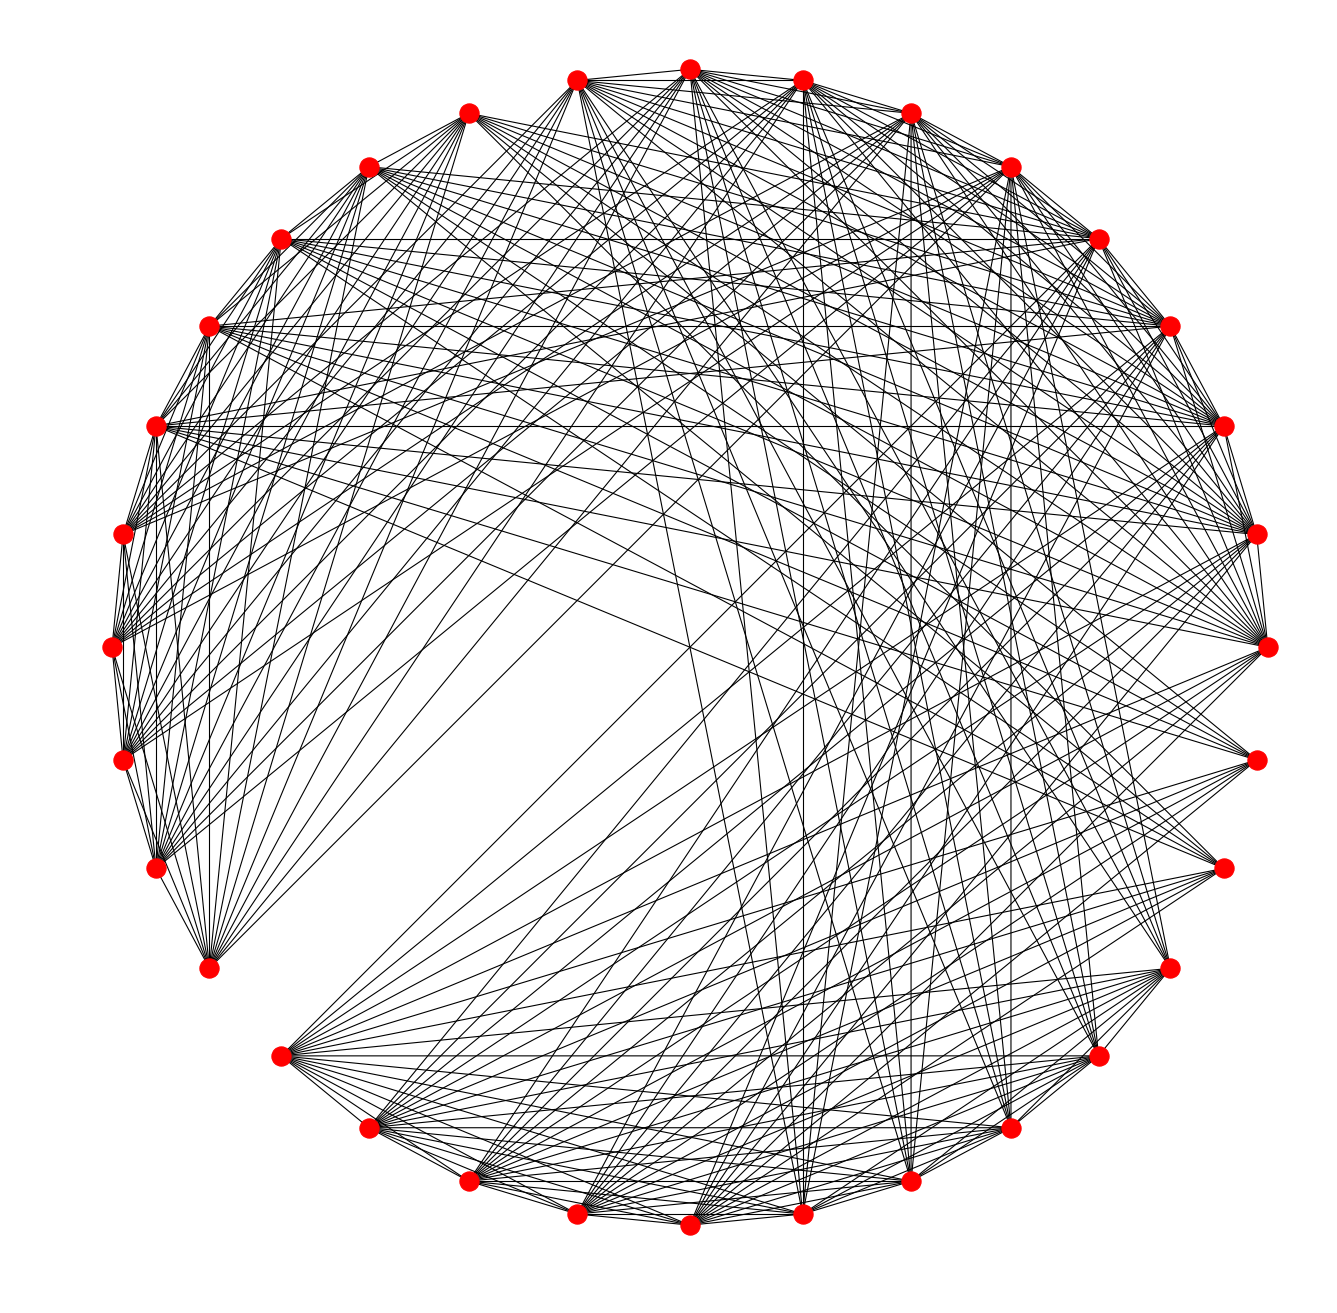

In [222]:
gh2l = nx.from_numpy_matrix(mascara_cubo_hipercubo(32,32))
plt.figure(num=None, figsize=(16, 16), dpi=80)
nx.draw(gh2l, pos=nx.circular_layout(gh2l))
plt.plot()

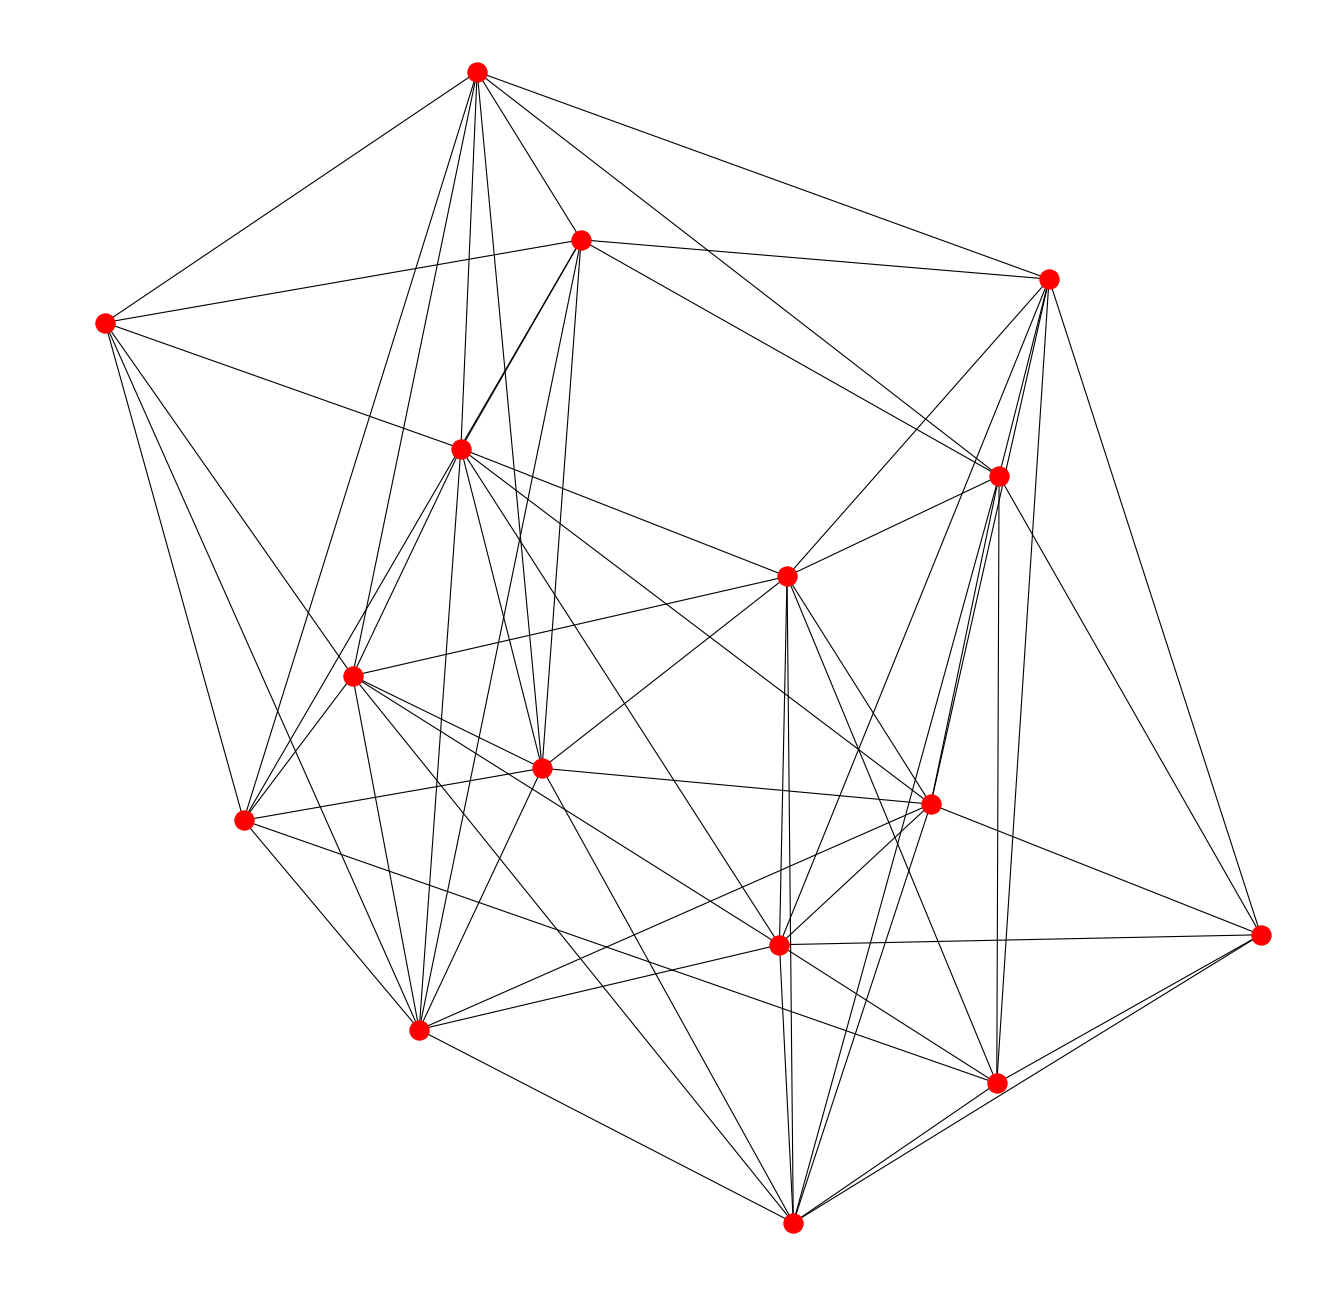

In [226]:
plt.figure(num=None, figsize=(16, 16), dpi=80)
nx.draw(nx.from_numpy_matrix(mascara_hipercubo2(16,16,0)))

[]

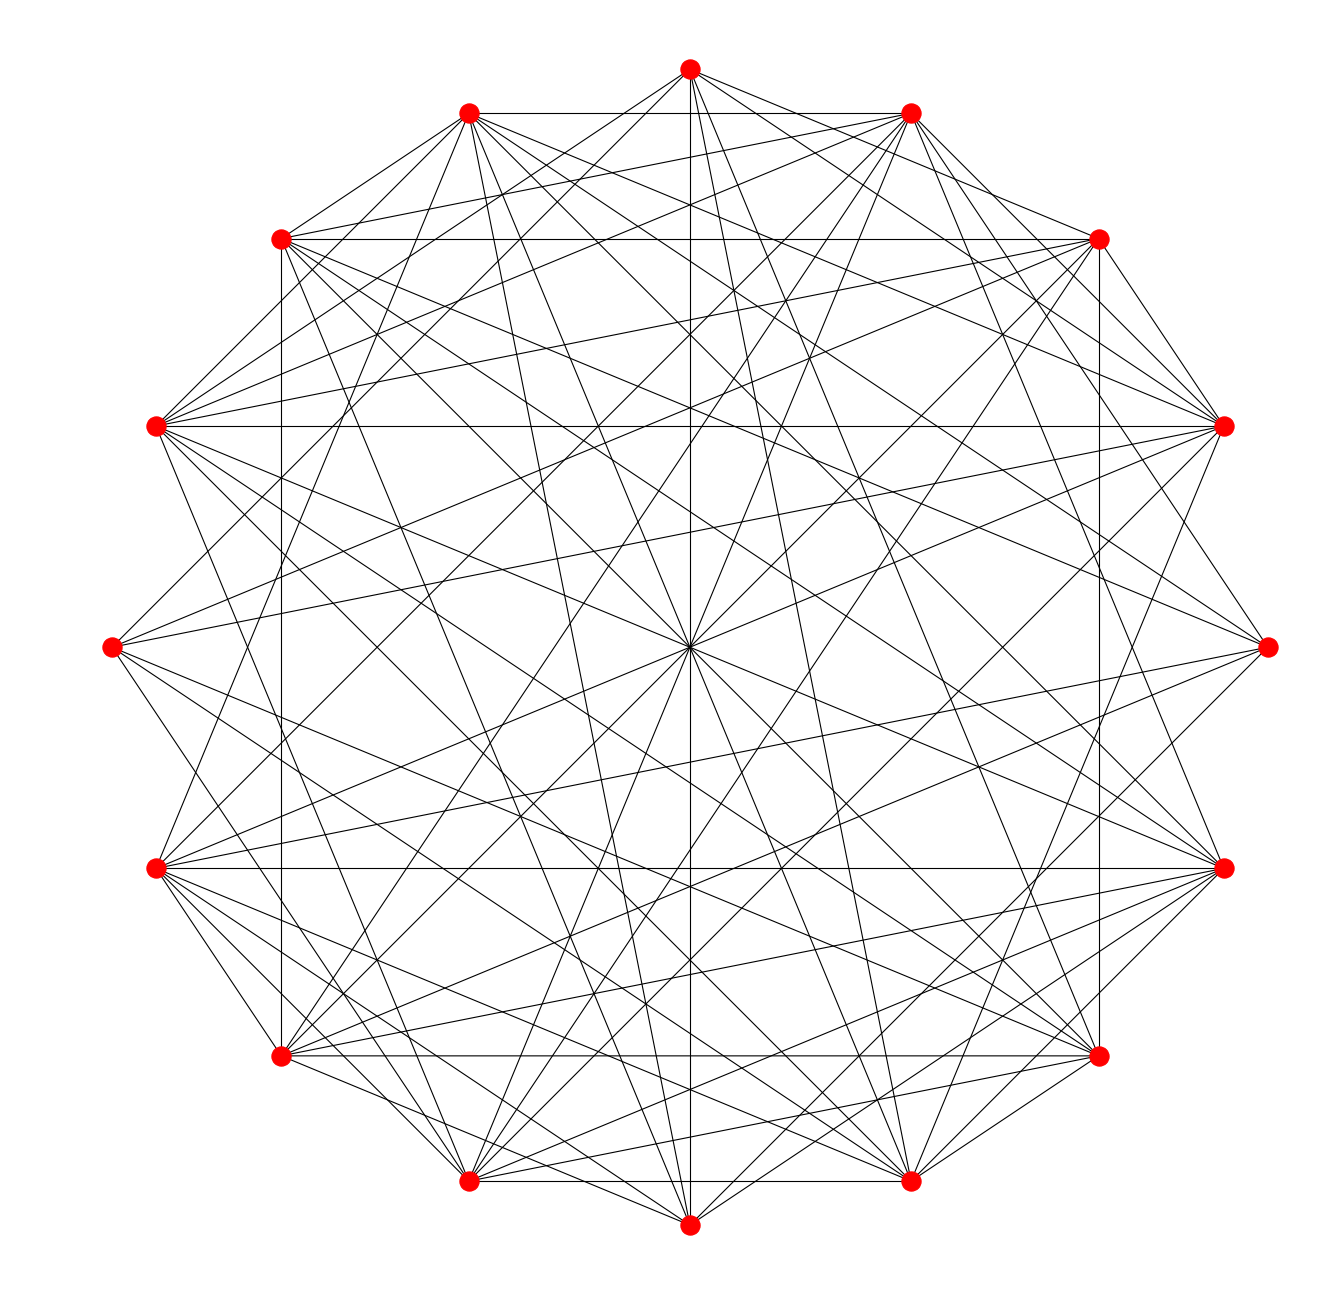

In [220]:
gh2 = nx.from_numpy_matrix(mascara_hipercubo2(16,16,0))
from matplotlib import pyplot as plt
plt.figure(num=None, figsize=(16, 16), dpi=80)
nx.draw(gh2, pos=nx.circular_layout(gh2))
plt.plot()

In [125]:
np.sum(mascara_hipercubo2(512,512,0))/(512**2)*100

5.078887939453125

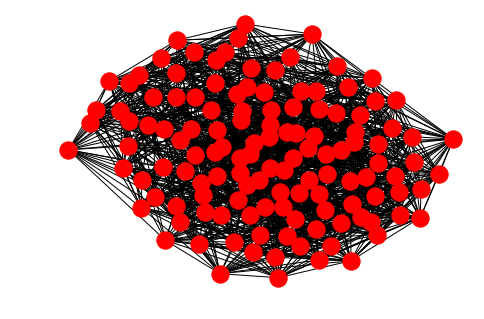

In [119]:
nx.draw(nx.from_numpy_matrix(mascara_hipercubo2(128,128)))

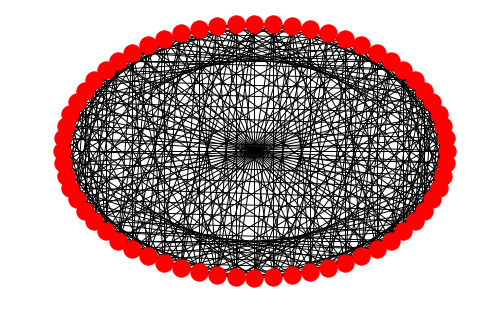

In [95]:
grafo = nx.from_numpy_matrix(mascara_hipercubo(64,64,1))
nx.draw(grafo, pos=nx.circular_layout(grafo))

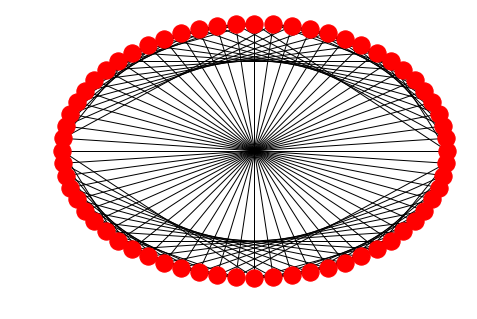

In [96]:
grafoH2= nx.from_numpy_matrix(mascara_hipercubo(64,64, 0))
nx.draw(grafoH2, pos=nx.circular_layout(grafoH2))

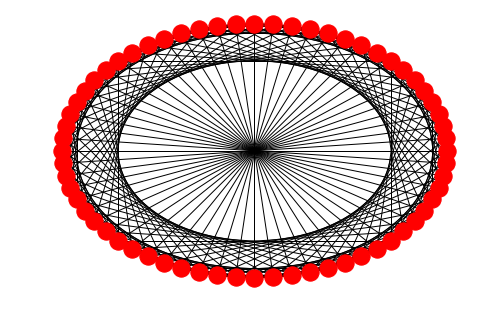

In [71]:
grafo2 = nx.from_numpy_matrix(mascara_esparsa(64,64,1))
nx.draw(grafo2, pos=nx.circular_layout(grafo2))

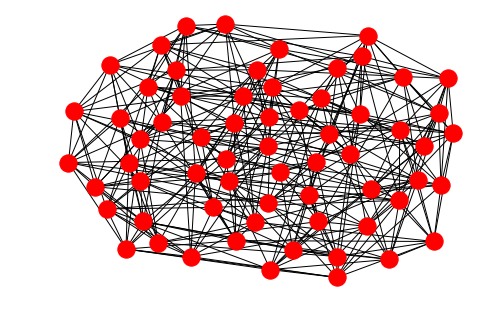

In [72]:
nx.draw(grafo2)

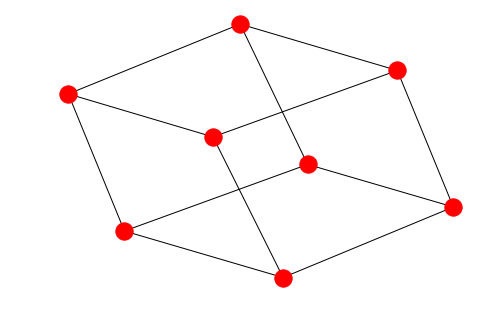

In [228]:
nx.draw(nx.from_numpy_matrix(mascara_hipercubo(8,8)))

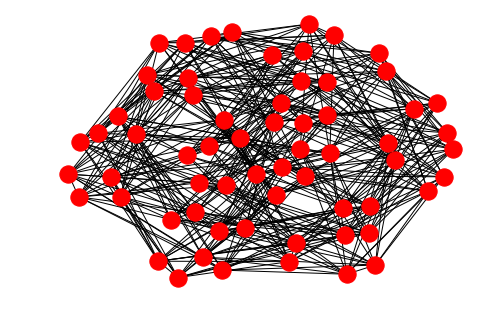

In [60]:
nx.draw(grafo)

In [70]:
np.sum(mascara_esparsa(9216, 128, 1))

129024.0

In [4]:
np.sum(mascara_esparsa(9216, 9216, 1))

248832.0

In [67]:
9216*128

1179648

In [6]:
mascara_esparsa(16,16,1)

array([[1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1.],
       [1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.],
       [1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1.],
       [1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,

In [66]:
np.sum(mascara_esparsa(16,16,1))

128.0

In [64]:
np.sum(mascara_hipercubo(16,16))

160.0

In [67]:
def qh(n):
    return n*(1+int(math.log2(n)))

In [68]:
qh(16)

80

In [90]:
mascara_hipercubo(16,16,0)

array([[1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,

In [91]:
mascara_hipercubo(16,16,1)

array([[1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1.],
       [1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1.],
       [0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0.],
       [1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.],
       [0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0.],
       [0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.],
       [1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1.],
       [1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1.],
       [0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0.],
       [0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0.],
       [1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.],
       [0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0.],
       [1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1.,

In [97]:
def p2(n):
    return 2**(2**n)

In [100]:
p2(3)

256

In [103]:
n=256
t = mascara_esparsa(n,n,1)
i=0
s = int(np.sum(t[0,:]))
l=[]
for j in range(n):
    if np.sum(t[i,:]+t[j,:]>0) == 2*s:
        l.append(j)

In [105]:
l

[11,
 13,
 19,
 21,
 22,
 23,
 25,
 26,
 27,
 29,
 35,
 37,
 38,
 39,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 57,
 58,
 59,
 61,
 67,
 69,
 70,
 71,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 121,
 122,
 123,
 125,
 131,
 133,
 134,
 135,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 185,
 186,
 187,
 189,
 195,
 197,
 198,
 199,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 217,
 218,
 219,
 221,
 227,
 229,
 230,
 231,
 233,
 234,
 235,
 237,
 243,
 245]

In [106]:
t[0,:]

array([1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0.

In [109]:
2*math.log2(10**11)**2

2670.5199167596793

## Benchmark MNIST

In [17]:
'''Trains a simple deep NN on the MNIST dataset.
Gets to 98.40% test accuracy after 20 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''
batch_size = 128
num_classes = 10
epochs = 20

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train/= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

60000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [=======================

In [29]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12741287865690834
Test accuracy: 0.9818


## Benchmark CNN (melhor)

In [8]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [47]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model2.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 171s 3ms/step - loss: 0.2717 - acc: 0.9153 - val_loss: 0.0662 - val_acc: 0.9785
Epoch 2/12
60000/60000 [==============================] - 173s 3ms/step - loss: 0.0874 - acc: 0.9739 - val_loss: 0.0500 - val_acc: 0.9841
Epoch 3/12
60000/60000 [==============================] - 173s 3ms/step - loss: 0.0657 - acc: 0.9801 - val_loss: 0.0335 - val_acc: 0.9892
Epoch 4/12
60000/60000 [==============================] - 174s 3ms/step - loss: 0.0531 - acc: 0.9839 - val_loss: 0.0329 - val_acc: 0.9883
Epoch 5/12
60000/60000 [==============================] - 175s 3ms/step - loss: 0.0467 - acc: 0.9857 - val_loss: 0.0311 - val_acc: 0.9899
Epoch 6/12
60000/60000 [==============================] - 175s 3ms/step - loss: 0.0417 - acc: 0.9875 - val_loss: 0.0294 - val_acc: 0.9900
Epoch 7/12
60000/60000 [=========================

In [64]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
__________

## Modelo com camadas esparsas

In [1]:
modelo = Sequential()
modelo.add(CamadaEsparsa(512, base=1, input_shape=(784,)))
modelo.add(Activation('relu'))
modelo.add(Dropout(0.2))
modelo.add(CamadaEsparsa(512, base=1))
modelo.add(Activation('relu'))
modelo.add(CamadaEsparsa(512, base=1))
modelo.add(Activation('relu'))
modelo.add(CamadaEsparsa(512, base=1))
modelo.add(Activation('relu'))
#modelo.add(Dropout(0.2))
modelo.add(Dense(num_classes, activation='softmax'))

modelo.summary()

modelo.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

historico = modelo.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_test, y_test))
escore = modelo.evaluate(x_test, y_test, verbose=0)
print('Test loss:', escore[0])
print('Test accuracy:', escore[1])

NameError: name 'Sequential' is not defined

In [30]:
modelo.layers[0].mascara.get_value()

array([[1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [29]:
_.value

Exception: sharedvar.value does not exist anymore. Use sharedvar.get_value() or sharedvar.set_value() instead.

In [61]:
modeloH = Sequential()
modeloH.add(CamadaHipercubo(512, input_shape=(784,)))
modeloH.add(Activation('relu'))
#modelo.add(Dropout(0.2))
modeloH.add(CamadaHipercubo(512))
modeloH.add(Activation('relu'))
modeloH.add(CamadaHipercubo(512))
modeloH.add(Activation('relu'))
modeloH.add(CamadaHipercubo(512))
modeloH.add(Activation('relu'))
#modelo.add(Dropout(0.2))
modeloH.add(Dense(num_classes, activation='softmax'))

modeloH.summary()

modeloH.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

historicoH = modeloH.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test))
escoreH = modeloH.evaluate(x_test, y_test, verbose=0)
print('Test loss:', escoreH[0])
print('Test accuracy:', escoreH[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
camada_hipercubo_9 (CamadaHi (None, 512)               401920    
_________________________________________________________________
activation_21 (Activation)   (None, 512)               0         
_________________________________________________________________
camada_hipercubo_10 (CamadaH (None, 512)               262656    
_________________________________________________________________
activation_22 (Activation)   (None, 512)               0         
_________________________________________________________________
camada_hipercubo_11 (CamadaH (None, 512)               262656    
_________________________________________________________________
activation_23 (Activation)   (None, 512)               0         
_________________________________________________________________
camada_hipercubo_12 (CamadaH (None, 512)               262656    
__________

NameError: name 'escore' is not defined

In [30]:
scoro = modelo.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scoro[0])
print('Test accuracy:', scoro[1])

Test loss: 0.08112920880344754
Test accuracy: 0.9797


In [62]:
print('Test loss:', escoreH[0])
print('Test accuracy:', escoreH[1])

Test loss: 0.08275110106276115
Test accuracy: 0.9776


In [ ]:
def camadaslc(modelo, quant)

modeloC = Sequential()
modeloC.add(CamadaEsparsa(512, base=1, input_shape=(784,)))
modeloC.add(Activation('relu'))
#modelo.add(Dropout(0.2))
modeloC.add(CamadaEsparsa(512, base=2))
modeloC.add(Activation('relu'))
modeloC.add(CamadaEsparsa(512, base=3))
modeloC.add(Activation('relu'))
modeloC.add(CamadaEsparsa(512, base=5))
modeloC.add(Activation('relu'))
#modelo.add(Dropout(0.2))
modeloC.add(Dense(num_classes, activation='softmax'))

modeloC.summary()

modeloC.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

historicoC = modeloC.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=60,
                    verbose=1,
                    validation_data=(x_test, y_test))
scoreC = modeloC.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scoreC[0])
print('Test accuracy:', scoreC[1])

## Modelo CNN com última camada esparsa

In [13]:
modelo2 = Sequential()
modelo2.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
modelo2.add(Conv2D(64, (3, 3), activation='relu'))
modelo2.add(MaxPooling2D(pool_size=(2, 2)))
modelo2.add(Dropout(0.25))
modelo2.add(Flatten())
modelo2.add(CamadaEsparsa(128, base=1))
modelo2.add(Activation('relu'))
modelo2.add(Dropout(0.15))
modelo2.add(Dense(num_classes, activation='softmax'))

modelo2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

modelo2.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))
avaliacao2 = modelo2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', avaliacao2[0])
print('Test accuracy:', avaliacao2[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 142s 2ms/step - loss: 0.3140 - acc: 0.9034 - val_loss: 0.0809 - val_acc: 0.9748
Epoch 2/12
60000/60000 [==============================] - 141s 2ms/step - loss: 0.0925 - acc: 0.9726 - val_loss: 0.0461 - val_acc: 0.9849
Epoch 3/12
60000/60000 [==============================] - 140s 2ms/step - loss: 0.0641 - acc: 0.9805 - val_loss: 0.0387 - val_acc: 0.9862
Epoch 4/12
60000/60000 [==============================] - 140s 2ms/step - loss: 0.0534 - acc: 0.9841 - val_loss: 0.0371 - val_acc: 0.9873
Epoch 5/12
60000/60000 [==============================] - 140s 2ms/step - loss: 0.0438 - acc: 0.9860 - val_loss: 0.0326 - val_acc: 0.9889
Epoch 6/12
60000/60000 [==============================] - 140s 2ms/step - loss: 0.0395 - acc: 0.9877 - val_loss: 0.0353 - val_acc: 0.9880
Epoch 7/12
60000/60000 [==============================] - 140s 2ms/step - loss: 0.0343 - acc: 0.9892 - val_loss: 0.0307 - 